# Tutorial 03: Waters compliance checking

The collision checker library provides a convenient way to construct the waters boundary for a scenario and check if the vessel is within the navigable water.


## 1. Load the scenario
We import necessary modules and load the example scenario.

/home/maioneb/.conda/envs/co38/lib/python3.8/site-packages/commonocean/visualization/traffic_sign.py:159: UserWarning: No png file for traffic sign id TrafficSignElementID.LATERAL_MARK_RED_A exists under path /home/maioneb/.conda/envs/co38/lib/python3.8/site-packages/commonocean/visualization/traffic_signs/101.png, skipped plotting.
  warnings.warn(


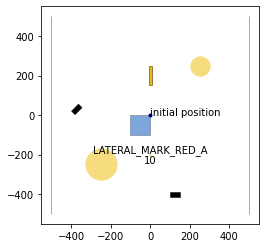

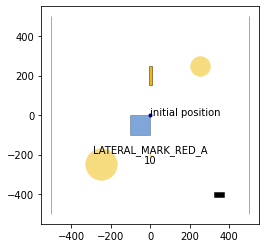

In [1]:
%matplotlib inline
import numpy as np
from time import time
import matplotlib.pyplot as plt


from commonocean.common.file_reader import CommonOceanFileReader
from commonocean.visualization.draw_dispatch_cr import draw_object
from commonroad.visualization.mp_renderer import MPRenderer


from commonocean_dc.boundary import boundary
from commonocean_dc.collision.trajectory_queries import trajectory_queries
from commonocean_dc.collision.collision_detection.pycrcc_collision_dispatch import create_collision_checker
import commonroad_dc.pycrcc as pycrcc


def open_scenario(scenario_filename):

    crfr = CommonOceanFileReader(
        scenario_filename)
    scenario, planning_problem_set = crfr.open()
    return scenario, planning_problem_set

#open the example scenario
scenario, planning_problem_set = open_scenario("CommonOceanDC_Tutorial.xml")

for j in [0,50, 105, 150]:
    draw_object(scenario, draw_params={'time_begin': j, 'trajectory_steps': 0})
    draw_object(planning_problem_set, draw_params={'time_begin': j})
    plt.gca().set_aspect('equal')
    plt.show()

## 2. Build the waters boundary

The drivability checker library provides several methods to check waters compliance. In particular, methods for the following three general approaches are implemented:
* **Waters boundary collision check (see Section 2.1.)**: checks whether the ego vessel trajectory collides with the boundary, which is approximated using simple shapes.
* **Occupancy inclusion (see Section 2.2.)**: checks whether the ego vessel occupancy is included within the drivable waters network for the entire trajectory.
* **Shallow overlapping (see Section 2.3.)**: checks whether the shallow areas are not overlapping navigable waterways and vice-versa.

All three approaches to check waters compliance are complementary to each other. Our toolbox provides different methods for each approach, which might differ in their performance. We demonstrate the methods in the following three sections.


### 2.1. Waters Boundary Collision Check
The waters boundary can be approximated using either triangulation (Section 2.1.1. - 2.1.3.) or oriented rectangles (Section 2.1.4.).

### 2.1.1. Delaunay Triangulation

In [2]:
time1=time()
waters_boundary_obstacle, waters_boundary_sg_triangles=boundary.create_waters_boundary_obstacle(scenario, method='triangulation')
time2=time()

print("Computation time: %s" % (time2-time1))

# draw the road boundary
rnd = MPRenderer(figsize=(25, 10))
waters_boundary_sg_triangles.draw(rnd)
rnd.render()

print("Number of boundary elements: %s" % waters_boundary_sg_triangles.size())

start: [[ 500. -500.]
 [-500. -500.]],left: [[-500. -500.]
 [-500.    0.]
 [-500.  500.]],end: [[-500.  500.]
 [ 500.  500.]],right: [[ 500.  500.]
 [ 500.    0.]
 [ 500. -500.]]
start: [[ 500. -500.]
 [-500. -500.]],left: [[-500. -500.]
 [-500.    0.]
 [-500.  500.]],end: [[-500.  500.]
 [ 500.  500.]],right: [[ 500.  500.]
 [ 500.    0.]
 [ 500. -500.]]
Computation time: 0.018329143524169922
Number of boundary elements: 13


### 2.1.2. Axis-Aligned Triangles (Horizontal)

start: [[ 500. -500.]
 [-500. -500.]],left: [[-500. -500.]
 [-500.    0.]
 [-500.  500.]],end: [[-500.  500.]
 [ 500.  500.]],right: [[ 500.  500.]
 [ 500.    0.]
 [ 500. -500.]]
Computation time: 0.11465167999267578
Number of boundary elements: 133


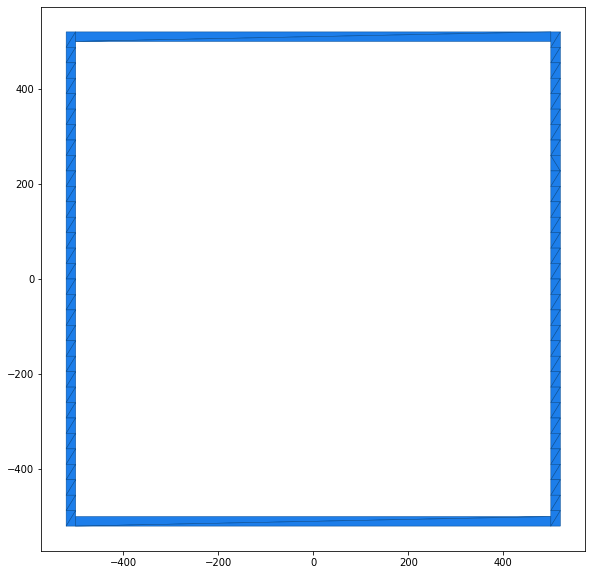

In [3]:
time1=time()
waters_boundary_obstacle, waters_boundary_sg_aligned_triangles=boundary.create_waters_boundary_obstacle(scenario, method='aligned_triangulation', axis=1)
time2=time()

print("Computation time: %s" % (time2-time1))

# draw the road boundary
rnd = MPRenderer(figsize=(25, 10))
waters_boundary_sg_aligned_triangles.draw(rnd)
rnd.render()

print("Number of boundary elements: %s" % waters_boundary_sg_aligned_triangles.size())

### 2.1.3. Axis-Aligned Triangles (Vertical)

start: [[ 500. -500.]
 [-500. -500.]],left: [[-500. -500.]
 [-500.    0.]
 [-500.  500.]],end: [[-500.  500.]
 [ 500.  500.]],right: [[ 500.  500.]
 [ 500.    0.]
 [ 500. -500.]]
Computation time: 0.11355996131896973
Number of boundary elements: 136


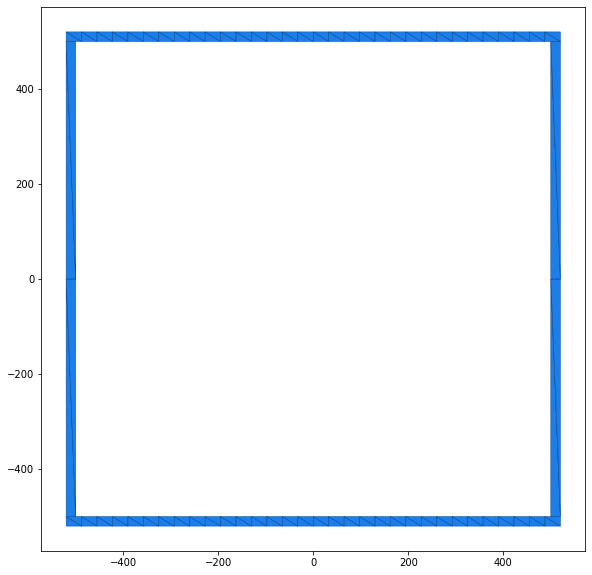

In [4]:
time1=time()
waters_boundary_obstacle, waters_boundary_sg_aligned_triangles=boundary.create_waters_boundary_obstacle(scenario, method='aligned_triangulation', axis=2)
time2=time()

print("Computation time: %s" % (time2-time1))

# draw the road boundary
rnd = MPRenderer(figsize=(25, 10))
waters_boundary_sg_aligned_triangles.draw(rnd)
rnd.render()

print("Number of boundary elements: %s" % waters_boundary_sg_aligned_triangles.size())

### 2.1.4. Oriented Rectangles

start: [[ 500. -500.]
 [-500. -500.]],left: [[-500. -500.]
 [-500.    0.]
 [-500.  500.]],end: [[-500.  500.]
 [ 500.  500.]],right: [[ 500.  500.]
 [ 500.    0.]
 [ 500. -500.]]
Computation time: 0.002360105514526367
Number of boundary elements: 6


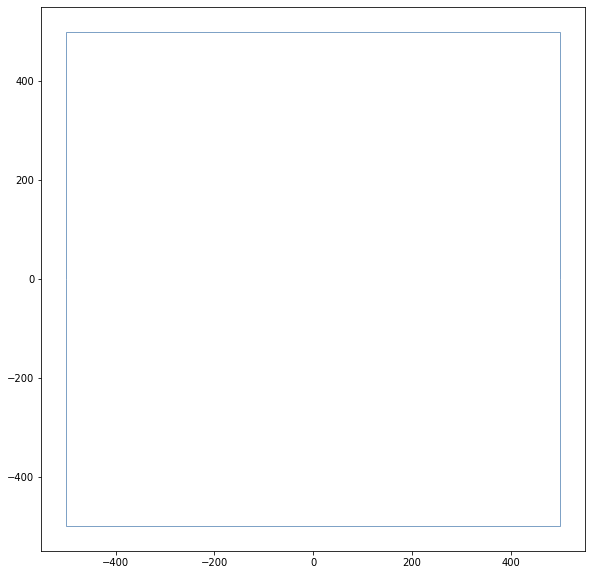

In [5]:
time1=time()
waters_boundary_obstacle, waters_boundary_sg_rectangles=boundary.create_waters_boundary_obstacle(scenario, method='obb_rectangles')
time2=time()

print("Computation time: %s" % (time2-time1))

# draw the road boundary
rnd = MPRenderer(figsize=(25, 10))
waters_boundary_sg_rectangles.draw(rnd)
rnd.render()

print("Number of boundary elements: %s" % waters_boundary_sg_rectangles.size())

## 2.2. Occupancy Inclusion
The occupancy inclusion approach represents the drivable waters network by a set of polygons. Three different methods are available to construct the polygons. The method is chosen by setting the parameter `method` accordingly in the function `boundary.create_road_polygons`.

### 2.2.1. Lane Polygons

In [6]:
time1=time()
waters_boundary_sg_polygons=boundary.create_waters_polygons(scenario, method='lane_polygons',buffer=1,resample=1, triangulate=False)
time2=time()

print("Computation time: %s" % (time2-time1))

# draw the road boundary
rnd = MPRenderer(figsize=(25, 10))
rnd.draw_params.shape.draw_mesh = False
waters_boundary_sg_polygons.draw(rnd)
rnd.render()

start: [[ 500. -500.]
 [-500. -500.]],left: [[-500. -500.]
 [-500.    0.]
 [-500.  500.]],end: [[-500.  500.]
 [ 500.  500.]],right: [[ 500.  500.]
 [ 500.    0.]
 [ 500. -500.]]
Computation time: 0.0015506744384765625


### 2.2.2. Polygons with Holes (Grid)

start: [[ 500. -500.]
 [-500. -500.]],left: [[-500. -500.]
 [-500.    0.]
 [-500.  500.]],end: [[-500.  500.]
 [ 500.  500.]],right: [[ 500.  500.]
 [ 500.    0.]
 [ 500. -500.]]
Computation time: 0.007826805114746094


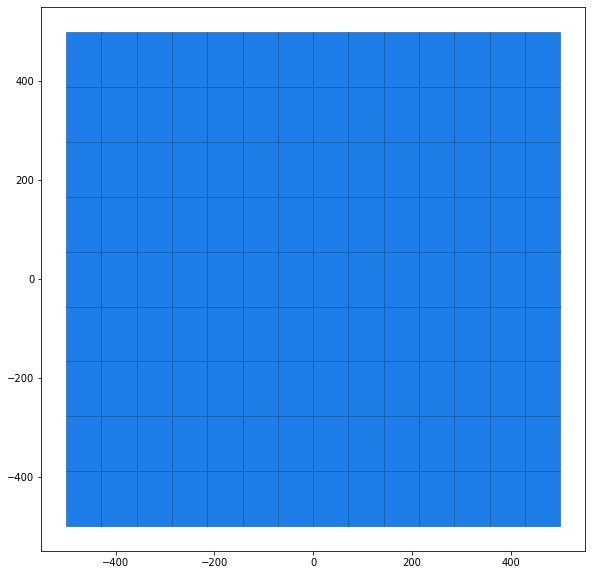

In [7]:
# length of the ego-vehicle
vessel_half_length=scenario.dynamic_obstacles[0].prediction.shape.length/2
# width of the ego-vehicle
vessel_half_width=scenario.dynamic_obstacles[0].prediction.shape.width/2

time1=time()
waters_boundary_sg_polygons_grid=boundary.create_waters_polygons(scenario, method='whole_polygon_tiled', max_cell_width=vessel_half_length*3, max_cell_height=vessel_half_length*5,triangulate=False)
time2=time()

print("Computation time: %s" % (time2-time1))

# draw the road boundary
rnd = MPRenderer(figsize=(25, 10))
rnd.draw_params.shape.draw_mesh = False
waters_boundary_sg_polygons_grid.draw(rnd)
rnd.render()

### 2.2.3. Polygons with Holes

In [8]:
time1=time()
waters_boundary_sg_polygons=boundary.create_waters_polygons(scenario, method='whole_polygon', triangulate=False)
time2=time()

print("Computation time: %s" % (time2-time1))

# draw the road boundary
rnd = MPRenderer(figsize=(25, 10))
rnd.draw_params.shape.draw_mesh = False
waters_boundary_sg_polygons.draw(rnd)
rnd.render()

start: [[ 500. -500.]
 [-500. -500.]],left: [[-500. -500.]
 [-500.    0.]
 [-500.  500.]],end: [[-500.  500.]
 [ 500.  500.]],right: [[ 500.  500.]
 [ 500.    0.]
 [ 500. -500.]]
Computation time: 0.0014760494232177734


### 2.2.4. Analogy for the Shallows of the Scenario

The same approach used for the WatersNetwork have an analogous version for the shallows of each scenario. Until now, the available method is the `lane_polygons`.

Computation time: 0.0003402233123779297


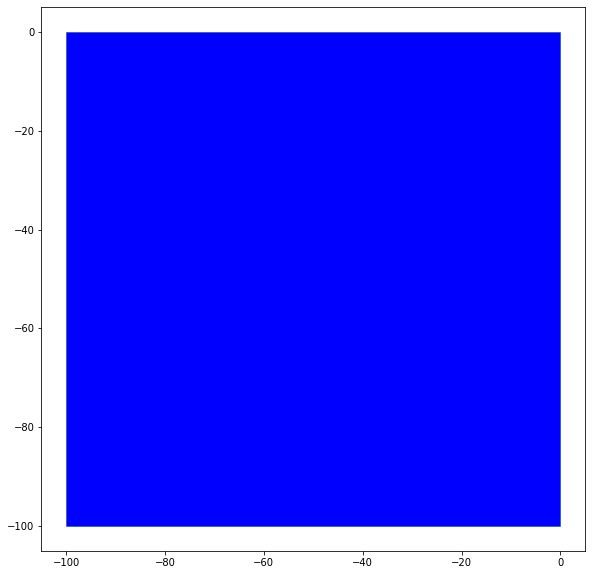

In [9]:
time1=time()
shallows_boundary_sg_polygons=boundary.create_shallow_polygons(scenario, method='lane_polygons',buffer=1,resample=1, triangulate=False)
time2=time()

print("Computation time: %s" % (time2-time1))
# draw the shallow boundary
rnd = MPRenderer(figsize=(25, 10))
rnd.draw_params.shape.draw_mesh = False
rnd.draw_params.shape.facecolor = "blue"
shallows_boundary_sg_polygons.draw(rnd)
rnd.render()

## 2.3. Shallow overlapping 

The shallow overlapping approach represents the conference whether the shallow objects are overlapping (colliding) with navigable waters objects. The method is straight forward and directly applicable through the function `boundary.overlapping_shallow_waters`. 

In [10]:
time1=time()
overlapping, shallow_waters_elements = boundary.overlapping_shallow_waters(scenario, method_waters='lane_polygons', method_shallow="lane_polygons", buffer=1,resample=1, triangulate=False)
time2=time()

print("Computation time: %s" % (time2-time1))
print('Overlapping between waters and shallow: ', overlapping)

# draw the shallow boundary
colors = ['#CD5555','blue']
i = 0
rnd = MPRenderer(figsize=(25, 10))
for element in shallow_waters_elements:
    rnd.draw_params.shape.draw_mesh = False
    rnd.draw_params.shape.facecolor = colors[i]
    element.draw(rnd)
    i += 1
rnd.render()

start: [[ 500. -500.]
 [-500. -500.]],left: [[-500. -500.]
 [-500.    0.]
 [-500.  500.]],end: [[-500.  500.]
 [ 500.  500.]],right: [[ 500.  500.]
 [ 500.    0.]
 [ 500. -500.]]
Computation time: 0.0017113685607910156
Overlapping between waters and shallow:  True


## 3. Check if the trajectory is within the water

After constructing a water boundary, we can check whether a given trajectory is water-compliant.

### 3.1. Select part of the trajectory for compliance checks

In [11]:
start_step=3

# half-length of the ego-vessel
vessel_half_length=scenario.dynamic_obstacles[0].prediction.shape.length/2
# half-width of the ego-vessel
vessel_half_width=scenario.dynamic_obstacles[0].prediction.shape.width/2

# list with trajectory states that are checked for collisions with the waters boundary
traj_list=list()
state_list=scenario.dynamic_obstacles[0].prediction.trajectory.state_list

# extract the positions (x,y) and orientation of the state list and store them in traj_list
for el in state_list[start_step:]:
    new_el=list()
    new_el.append(el.position[0])   # position x
    new_el.append(el.position[1])   # position y
    new_el.append(el.orientation)   # orientation
    traj_list.append(new_el)
    
# create an oriented rectangle (RectOBB) for the ego vehicle at Step i of the traj_list
i=0
obb=pycrcc.RectOBB(vessel_half_length, vessel_half_width, traj_list[i][2],traj_list[i][0],traj_list[i][1])
waters_boundary_obstacle, waters_boundary_sg_triangles=boundary.create_waters_boundary_obstacle(scenario, method='triangulation')


# draw the ego vessel at time step i, please note the x and y values of the graph
rnd = MPRenderer(figsize=(25, 10))
rnd.draw_params.shape.facecolor = "green"
obb.draw(rnd)
rnd.render()

start: [[ 500. -500.]
 [-500. -500.]],left: [[-500. -500.]
 [-500.    0.]
 [-500.  500.]],end: [[-500.  500.]
 [ 500.  500.]],right: [[ 500.  500.]
 [ 500.    0.]
 [ 500. -500.]]
start: [[ 500. -500.]
 [-500. -500.]],left: [[-500. -500.]
 [-500.    0.]
 [-500.  500.]],end: [[-500.  500.]
 [ 500.  500.]],right: [[ 500.  500.]
 [ 500.    0.]
 [ 500. -500.]]


We create a time-variant collision object for the ego vessel.

In [12]:
def create_tvobstacle(traj_list,vessel_half_length,vessel_half_width):
    tvo=pycrcc.TimeVariantCollisionObject(0)
    for traj in traj_list:
        tvo.append_obstacle(pycrcc.RectOBB(vessel_half_length, vessel_half_width, traj[2],traj[0],traj[1]))
    return tvo

co=create_tvobstacle(traj_list,vessel_half_length,vessel_half_width)

Next, we preprocess the time-variant collision object (ego vessel) for continuous collision detection: We construct an oriented bounding box (OBB) around the occupancies for two consecutive time steps. The trajectory of the resulting time-variant collision object is one time step smaller than the original trajectory.

In [13]:
# preprocess using OBB sum hull
preprocessed_trajectory, err=trajectory_queries.trajectory_preprocess_obb_sum(co)
if(err):
    raise Exception("trajectory preprocessing error")

We can then check whether the trajectories are compliant to the waters network using the approaches described above:

### Approach 1: Road boundary collision checks

#### Triangulation

In [14]:
# compute time step of collision with waters boundary using triangulation
waters_boundary_obstacle, waters_boundary_sg_triangles=boundary.create_waters_boundary_obstacle(scenario, method='triangulation')
ret=trajectory_queries.trajectories_collision_static_obstacles([preprocessed_trajectory], waters_boundary_sg_triangles, method='grid', num_cells=32, auto_orientation=True)
if ret[0] == -1:
    print('No collision')
else:
    print('First time step of collision: %s' % ret[0])

start: [[ 500. -500.]
 [-500. -500.]],left: [[-500. -500.]
 [-500.    0.]
 [-500.  500.]],end: [[-500.  500.]
 [ 500.  500.]],right: [[ 500.  500.]
 [ 500.    0.]
 [ 500. -500.]]
start: [[ 500. -500.]
 [-500. -500.]],left: [[-500. -500.]
 [-500.    0.]
 [-500.  500.]],end: [[-500.  500.]
 [ 500.  500.]],right: [[ 500.  500.]
 [ 500.    0.]
 [ 500. -500.]]
No collision


#### Oriented Rectangles

In [15]:
# compute time step of collision with road boundary using oriented rectangles
waters_boundary_obstacle, waters_boundary_sg_rectangles=boundary.create_waters_boundary_obstacle(scenario, method='obb_rectangles')
ret=trajectory_queries.trajectories_collision_static_obstacles([preprocessed_trajectory], waters_boundary_sg_rectangles, method='grid', num_cells=32, auto_orientation=True)
if ret[0] == -1:
    print('No collision')
else:
    print('First time step of collision: %s' % ret[0])


start: [[ 500. -500.]
 [-500. -500.]],left: [[-500. -500.]
 [-500.    0.]
 [-500.  500.]],end: [[-500.  500.]
 [ 500.  500.]],right: [[ 500.  500.]
 [ 500.    0.]
 [ 500. -500.]]
No collision


### Approach 2: Occupancy Inclusion

#### Polygons with holes (grid)

In [16]:
# check trajectory enclosure using waters polygon
waters_boundary_sg_polygons_grid=boundary.create_waters_polygons(scenario, method='whole_polygon_tiled', max_cell_width=vessel_half_length*3, max_cell_height=vessel_half_length*5,triangulate=False)
ret=trajectory_queries.trajectories_enclosure_polygons_static([preprocessed_trajectory], waters_boundary_sg_polygons_grid, method='grid', num_cells=32, enable_verification=False)
if ret[0] == -1:
    print('Trajectory completely enclosed')
else:
    print('First time step of incomplete enclosure: %s' % ret[0])


start: [[ 500. -500.]
 [-500. -500.]],left: [[-500. -500.]
 [-500.    0.]
 [-500.  500.]],end: [[-500.  500.]
 [ 500.  500.]],right: [[ 500.  500.]
 [ 500.    0.]
 [ 500. -500.]]
Trajectory completely enclosed


## 4. Minkowski sum for road boundary

As demonstrated in *Tutorial 02: CommonOcean Interface*, our toolbox allows us to compute the minkowski sum with a circle
for any *commonocean-io* shape. The same can be done for the waters boundary obstacle when using approach 1 for waters compliance
checking. As shown below, we can inflate the waters boundary obstacle which corresponds to specifying a safety distance
the vehicle should keep to the waters boundary.


In [18]:
# create road boundary obstacle (here using oriented rectangles)
waters_boundary_obstacle, waters_boundary_sg_rectangles=boundary.create_waters_boundary_obstacle(scenario, method='obb_rectangles')

# add road boundary as static obstacle to scenario
scenario.add_objects(waters_boundary_obstacle)

# create collision checker for scenario
cc = create_collision_checker(scenario, params={'minkowski_sum_circle': True,
                                                'minkowski_sum_circle_radius': 1.0,
                                                'resolution': 4})

# visualize scenario and collision objects
rnd = MPRenderer(figsize=(25, 10))
rnd.draw_params.shape.draw_mesh = True
rnd.draw_params.shape.facecolor = "blue"
cc.draw(rnd)
rnd.render()

draw_object(planning_problem_set, draw_params={'time_begin': 0})
plt.gca().set_aspect('equal')
plt.show()

start: [[ 500. -500.]
 [-500. -500.]],left: [[-500. -500.]
 [-500.    0.]
 [-500.  500.]],end: [[-500.  500.]
 [ 500.  500.]],right: [[ 500.  500.]
 [ 500.    0.]
 [ 500. -500.]]
